#### Copyright 2020 Google LLC.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# k-means


k-means clustering is an *unsupervised* machine learning algorithm that can be used to group items into clusters.

So far we have only worked with supervised algorithms. Supervised algorithms have training data with labels that identify the numeric value or class for each item. These algorithms use labeled data to build a model that can be used to make predictions.

k-means clustering is different. The training data is not labeled. Unlabeled training data is fed into the model, which attempts to find relationships in the data and create clusters based on those relationships. Once these clusters are formed, predictions can be made about which cluster new data items belong to.

The clusters can't easily be labeled in many cases. The clusters are "emergent clusters" and are created by the algorithm. They don't always map to groupings that you might expect.

## Example: Groups of Mushrooms

Let's start by looking at a real world use case involving mushrooms. The University of California Irvine has a [dataset containing various attributes of mushrooms](https://www.kaggle.com/uciml/mushroom-classification). One of those attributes is the edibility of the mushroom: Is it edible or is it poisonous?  We want to see if we can find clusters of mushroom attributes that can be used to determine if a mushroom is edible or not.

### Load the Data

For this example we'll load the [mushroom classification](https://www.kaggle.com/uciml/mushroom-classification) data. The dataset attributes about over `8,000` different mushrooms.

Upload your `kaggle.json` file and run the code block below.

In [ ]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

chmod: cannot access 'kaggle.json': No such file or directory


And then use the Kaggle API to download the dataset.

In [ ]:
! kaggle datasets download uciml/mushroom-classification
! ls

mushroom-classification.zip: Skipping, found more recently modified local copy (use --force to force download)
mushroom-classification.zip  mushrooms.csv  sample_data


Unzip the Data.

In [ ]:
! unzip mushroom-classification.zip
! ls

Archive:  mushroom-classification.zip
replace mushrooms.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
mushroom-classification.zip  mushrooms.csv  sample_data


And finally, load the training data into a `DataFrame`.

In [ ]:
import pandas as pd

data = pd.read_csv('mushrooms.csv')
data.sample(n=10)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
695,e,b,y,w,t,a,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,s,g
5710,p,f,s,w,t,f,f,c,b,p,t,b,f,f,w,w,p,w,o,p,h,v,u
1918,e,f,f,n,f,n,f,w,b,k,t,e,s,f,w,w,p,w,o,e,k,s,g
4185,p,x,f,g,f,f,f,c,b,g,e,b,k,k,p,p,p,w,o,l,h,y,p
6025,p,x,s,n,f,s,f,c,n,b,t,?,k,k,w,w,p,w,o,e,w,v,p
6273,p,x,s,n,f,f,f,c,n,b,t,?,s,k,p,p,p,w,o,e,w,v,l
3260,e,f,y,g,t,n,f,c,b,p,t,b,s,s,g,p,p,w,o,p,k,y,d
7659,e,k,f,w,f,n,f,w,b,w,e,?,s,k,w,w,p,w,t,p,w,s,g
3418,p,x,s,g,f,c,f,c,n,p,e,b,s,s,w,w,p,w,o,p,n,s,d
4987,p,x,y,y,f,f,f,c,b,p,e,b,k,k,p,n,p,w,o,l,h,v,g


### Exploratory Data Analysis

Let's take a closer look at the data that we'll be working with, starting with a simple describe.

In [ ]:
data.describe(include='all')

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,2,5,4,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,t,b,s,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,3776,5176,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


It doesn't look like any columns are missing data since we see counts of `8,124` for every column.

It does look like all of the data is categorical. We'll need to convert it into numeric values for the model to work. Let's do it for every column except `class`. We aren't trying to predict class, but we do want to see if we can get pure clusters of one type of class. So we don't want it included in our training data. Also, it is the only feature that isn't observable without having dire consequences!

In [ ]:
columns = [c for c in data.columns.values if c != 'class']
id_to_value_mappings = {}
value_to_id_mappings = {}

for column in columns:
  i_to_v = sorted(data[column].unique())
  v_to_i = { v:i for i, v in enumerate(i_to_v)}
  

  numeric_column = column + '-id'
  data[numeric_column] = [v_to_i[v] for v in data[column]]

  value_to_id_mappings[column] = v_to_i
  id_to_value_mappings[numeric_column] = i_to_v

numeric_columns = id_to_value_mappings.keys()
data[numeric_columns].describe()

,cap-shape-id,cap-surface-id,cap-color-id,bruises-id,odor-id,gill-attachment-id,gill-spacing-id,gill-size-id,gill-color-id,stalk-shape-id,stalk-root-id,stalk-surface-above-ring-id,stalk-surface-below-ring-id,stalk-color-above-ring-id,stalk-color-below-ring-id,veil-type-id,veil-color-id,ring-number-id,ring-type-id,spore-print-color-id,population-id,habitat-id
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.0,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,3.348104,1.827671,4.504677,0.415559,4.144756,0.974151,0.161497,0.309207,4.810684,0.567208,1.109798,1.575086,1.603644,5.816347,5.794682,0.0,1.965534,1.069424,2.291974,3.596750,3.644018,1.508616
std,1.604329,1.229873,2.545821,0.492848,2.103729,0.158695,0.368011,0.462195,3.540359,0.495493,1.061106,0.621459,0.675974,1.901747,1.907291,0.0,0.242669,0.271064,1.801672,2.382663,1.252082,1.719975
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,0.000000,2.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,6.000000,6.000000,0.0,2.000000,1.000000,0.000000,2.000000,3.000000,0.000000
50%,3.000000,2.000000,4.000000,0.000000,5.000000,1.000000,0.000000,0.000000,5.000000,1.000000,1.000000,2.000000,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,2.000000,3.000000,4.000000,1.000000
75%,5.000000,3.000000,8.000000,1.000000,5.000000,1.000000,0.000000,1.000000,7.000000,1.000000,1.000000,2.000000,2.000000,7.000000,7.000000,0.0,2.000000,1.000000,4.000000,7.000000,4.000000,2.000000
max,5.000000,3.000000,9.000000,1.000000,8.000000,1.000000,1.000000,1.000000,11.000000,1.000000,4.000000,3.000000,3.000000,8.000000,8.000000,0.0,3.000000,2.000000,4.000000,8.000000,5.000000,6.000000


### Perform Clustering

We now have numeric data that a model can handle. To run k-means clustering on the data, we simply load [k-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) from scikit-learn and ask the model to find a specific number of clusters for us.

Notice that we are scaling the data. The class IDs are integer values, and some columns have many more classes than others. Scaling helps make sure that columns with more classes don't have an undue influence on the model.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

model = KMeans(n_clusters=10)
model.fit(scale(data[numeric_columns]))

print(model.inertia_)

60210.87435141582


We asked scikit-learn to create 10 clusters for us, and then we printed out the `inertia_` for the resultant clusters. *Inertia* is the sum of the squared distances of samples to their closest cluster center. Typically, the smaller the inertia the better.

But why did we choose `10` clusters? And is the inertia that we received reasonable?

### Find the Optimal Number of Clusters

With just one run of the algorithm, it is difficult to tell how many clusters we should have and what an appropriate inertia value is. k-means is trying to discover things about your data that you do not know. Picking a number of clusters at random isn't the best way to use k-means.

Instead, you should experiment with a few different cluster values and measure the inertia of each. As you increase the number of clusters, your inertia should decrease.

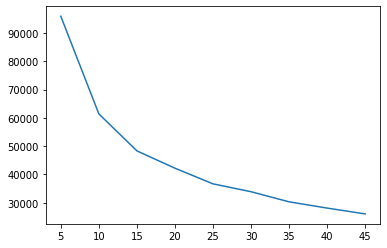

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

clusters = list(range(5, 50, 5))
inertias = []

scaled_data = scale(data[numeric_columns])

for c in clusters:
  model = KMeans(n_clusters=c)
  model = model.fit(scaled_data)
  inertias.append(model.inertia_)

plt.plot(clusters, inertias)
plt.show()

The resulting graph should start high and to the left and curve down as the number of clusters grows. The initial slope is steep, but begins to level off. Your optimal number of clusters is somewhere in the ["elbow" of the graph](https://en.wikipedia.org/wiki/Elbow_method_(clustering) as the slope levels.

Once you have this number, you need to then check to see if the number is reasonable for your use case. Say that the 'optimal' number of clusters for our mushroom identification is 15. Is that a reasonable number of clusters to deal with? If we have too many, we can overfit and make the model poor at generalizing. And what are the purposes of the clusters? If you are clustering mushrooms and want to find clusters that are definitely safe to eat, 15 or more clusters might be perfectly fine. If you are clustering customers for different advertising campaigns, 15 different campaigns might be more than your marketing department can handle.

Clustering the data is often just the start of your journey. Once you have clusters, you'll need to look at each group and try to determine what makes them similar. What patterns did the clustering find? And will that clustering be useful to you?

### Examining Clusters

Let's say that `15` is a reasonable number of clusters. We can rebuild the model using that setting.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale

model = KMeans(n_clusters=15)
model.fit(scale(data[numeric_columns]))

print(model.inertia_)

48312.365847337496


Now let's see if we have any 'pure' clusters. These are clusters with all-edible or all-poisonous mushrooms.

In [ ]:
import numpy as np

for cluster in sorted(np.unique(model.labels_)):
  num_edible = np.sum(data[model.labels_ == cluster]['class'] == 'e')
  total = np.sum(model.labels_ == cluster)
  print(cluster, num_edible / total)

0 1.0
1 0.9707865168539326
2 0.0
3 0.05263157894736842
4 0.8235294117647058
5 0.2727272727272727
6 0.9142857142857143
7 0.0
8 0.9723756906077348
9 0.0
10 0.0
11 1.0
12 1.0
13 1.0
14 0.3567567567567568


In our model we had clusters `0`, `1`, `6`, and `10` be `100%` edible. Clusters `2`, `4`, `7`, and `12` were all poisonous. The remaining were a mix of the two.

Knowing this, let's look at one of the all-edible clusters and see what attributes we could look for to have confidence that we have an edible mushroom.

In [ ]:
edible = data[model.labels_ == 1]

for column in edible.columns:
  if column.endswith('-id'):
    continue
  print(column, edible[column].unique())


class ['e' 'p']
cap-shape ['x' 'f']
cap-surface ['y' 's']
cap-color ['g' 'e' 'n' 'b' 'w']
bruises ['t']
odor ['n' 'f']
gill-attachment ['f']
gill-spacing ['c']
gill-size ['b']
gill-color ['n' 'u' 'w' 'p' 'h']
stalk-shape ['t']
stalk-root ['b']
stalk-surface-above-ring ['s']
stalk-surface-below-ring ['s']
stalk-color-above-ring ['g' 'p' 'w']
stalk-color-below-ring ['w' 'p' 'g']
veil-type ['p']
veil-color ['w']
ring-number ['o']
ring-type ['p']
spore-print-color ['n' 'k' 'h']
population ['y' 'v' 's']
habitat ['d' 'g']


The mapping of the letter codes to more descriptive text can be found in the [dataset description](https://www.kaggle.com/uciml/mushroom-classification).

## Example: Classification of Digits

Clustering for data exploration purposes can lead to interesting insights in to your data, but clustering can also be used for classification purposes.

In the example below, we'll try to use k-means clustering to predict handwritten digits.

### Load the Data

We'll load the digits dataset packaged with scikit-learn.

In [ ]:
from sklearn.datasets import load_digits

digits = load_digits()

### Scale the Data

It is good practice to scale the data to ensure that outliers don't have too big of an impact on the clustering.

In [ ]:
from sklearn.preprocessing import scale

scaled_digits = scale(digits.data)

### Fit a Model

We can then create a k-means model with 10 clusters. (We know there are 10 digits from 0 through 9.)

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=10)
model = model.fit(scaled_digits)

### Make Predictions

We can then use the model to predict which category a data point belongs to.

In the case below, we'll just use some of the data that we trained with for illustrative purposes. The prediction will provide a numeric value.

In [ ]:
cluster = model.predict([scaled_digits[0]])[0]

cluster

2

What is this value? Is it the predicted digit?

No. This number is the cluster that the model thinks the digit belongs to. To determine the predicted digit, we'll need to see what other digits are in the cluster and choose the most popular one for our classification.


In [ ]:
import numpy as np

labels = digits.target

cluster_to_digit = [
  np.argmax(
      np.bincount(
        np.array(
          [labels[i] for i in range(len(model.labels_)) if model.labels_[i] == cluster]
        )
      )
    ) for cluster in range(10)
]

cluster_to_digit

[8, 6, 0, 7, 3, 1, 2, 5, 4, 7]

Here we can see the digit that each cluster represents.

### Measure Model Quality

If we do have labeled data, as is the case with our digits data, then we can measure the quality of our model using the [homogeneity score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score_) and the [completeness score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score).

In [ ]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

homogeneity = homogeneity_score(labels, model.labels_)
completeness = completeness_score(labels, model.labels_)
homogeneity, completeness

(0.6753056654215962, 0.7161031636370648)

# Exercises

## Exercise 1

Load the [iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), create a k-means model with three clusters, and then find the homogeneity and completeness scores for the model. 

### **Student Solution**

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

from sklearn.preprocessing import scale

scaled_iris = scale(iris.data)

from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model = model.fit(scaled_iris)

# cluster = model.predict([scaled_iris[0]])[0]

import numpy as np

labels = iris.target

cluster_to_digit = [
  np.argmax(
      np.bincount(
        np.array(
          [labels[i] for i in range(len(model.labels_)) if model.labels_[i] == cluster]
        )
      )
    ) for cluster in range(3)
]

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

print(model.inertia_,
      homogeneity_score(labels, model.labels_),
      completeness_score(labels, model.labels_))

139.82049635974982 0.6591265018049008 0.6598476779627759


---

## Exercise 2

Load the [iris dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html), and then create a k-means model with three clusters using only two features. (Try to find the best two features for clustering.) Create a plot of the two features.

For each datapoint in the chart, use a [marker](https://matplotlib.org/api/markers_api.html) to encode the actual/correct species. For instance, use a triangle for Setosa, a square for Versicolour, and a circle for Virginica. Color each marker green if the predicted class matches the actual. Color each marker red if the classes don't match.

### **Student Solution**

In [ ]:
scaled_iris.shape

(150, 2)

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris()

from sklearn.preprocessing import scale

scaled_iris = scale(iris.data[:, 2:])

from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
model = model.fit(scaled_iris)

cluster = model.predict(scaled_iris)

import numpy as np

labels = iris.target

cluster_to_digit = [
  np.argmax(
      np.bincount(
        np.array(
          [labels[i] for i in range(len(model.labels_)) if model.labels_[i] == cluster]
        )
      )
    ) for cluster in range(3)
]

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score

print(model.inertia_,
      homogeneity_score(labels, model.labels_),
      completeness_score(labels, model.labels_))

18.026962612544068 0.8639756867013153 0.8643954288752762


In [ ]:
cluster_to_digit

[2, 0, 1]

In [ ]:
cluster_label_dict = {0:2, 1:0, 2:1}
cluster_labels = [cluster_label_dict[k] for k in cluster]

In [ ]:
import pandas as pd

df = pd.DataFrame(iris.data[:, 2:], columns=iris.feature_names[2:])
df = df.assign(target = iris.target)
df = df.assign(guesses = cluster_labels)
df['color'] = np.where(
    df.target == df.guesses, 'Correct', 'Incorrect')
# df['marker'] = np.where(
#     df.target == 0, '^', np.where(
#         df.target == 1, 's', 'o'))
df

,petal length (cm),petal width (cm),target,guesses,color
0,1.4,0.2,0,0,Correct
1,1.4,0.2,0,0,Correct
2,1.3,0.2,0,0,Correct
3,1.5,0.2,0,0,Correct
4,1.4,0.2,0,0,Correct
...,...,...,...,...,...
145,5.2,2.3,2,2,Correct
146,5.0,1.9,2,2,Correct
147,5.2,2.0,2,2,Correct
148,5.4,2.3,2,2,Correct


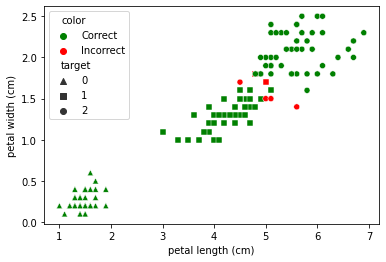

In [ ]:
from seaborn import scatterplot

markers = {0:'^', 1:'s', 2:'o'}

scatterplot(
    data=df,
    x=iris.feature_names[2],
    y=iris.feature_names[3],
    hue='color',
    palette=['green', 'red'],
    style='target',
    markers=markers
)

---